Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

# Some personnal imports
import matplotlib.pyplot as plt
%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

First, let's do the multinomial logistic regression.

In [16]:
# Build the graph.

batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
    
  # This is the coefficient before L2 regularization 
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  w = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
  b = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, w) + b

  # Loss.
  loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
  ) + beta_regul * tf.nn.l2_loss(w)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, w) + b)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, w) + b)

In [17]:
# Run the graph with a fixed beta value.

num_steps = 3001
batch_size = 128
beta_val = 1e-3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Graph initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta_val}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Graph initialized
Minibatch loss at step 0: 21.496843
Minibatch accuracy: 12.5%
Validation accuracy: 12.6%
Minibatch loss at step 500: 3.175725
Minibatch accuracy: 72.7%
Validation accuracy: 76.4%
Minibatch loss at step 1000: 2.120925
Minibatch accuracy: 72.7%
Validation accuracy: 78.8%
Minibatch loss at step 1500: 1.202325
Minibatch accuracy: 81.2%
Validation accuracy: 80.3%
Minibatch loss at step 2000: 1.079453
Minibatch accuracy: 76.6%
Validation accuracy: 80.6%
Minibatch loss at step 2500: 1.068426
Minibatch accuracy: 75.0%
Validation accuracy: 82.1%
Minibatch loss at step 3000: 0.696453
Minibatch accuracy: 85.2%
Validation accuracy: 82.5%
Test accuracy: 87.9%


Beta value: 0.0001, Test accuracy: 85.9%
Beta value: 0.00012742749857, Test accuracy: 86.3%
Beta value: 0.000162377673919, Test accuracy: 86.5%
Beta value: 0.000206913808111, Test accuracy: 86.3%
Beta value: 0.000263665089873, Test accuracy: 87.0%
Beta value: 0.000335981828628, Test accuracy: 87.0%
Beta value: 0.000428133239872, Test accuracy: 87.3%
Beta value: 0.000545559478117, Test accuracy: 87.9%
Beta value: 0.000695192796178, Test accuracy: 87.6%
Beta value: 0.00088586679041, Test accuracy: 87.9%
Beta value: 0.00112883789168, Test accuracy: 87.8%
Beta value: 0.00143844988829, Test accuracy: 88.1%
Beta value: 0.00183298071083, Test accuracy: 87.9%
Beta value: 0.00233572146909, Test accuracy: 87.8%
Beta value: 0.00297635144163, Test accuracy: 87.7%
Beta value: 0.00379269019073, Test accuracy: 87.6%
Beta value: 0.00483293023857, Test accuracy: 87.5%
Beta value: 0.00615848211066, Test accuracy: 87.3%
Beta value: 0.00784759970351, Test accuracy: 87.2%
Beta value: 0.01, Test accuracy: 8

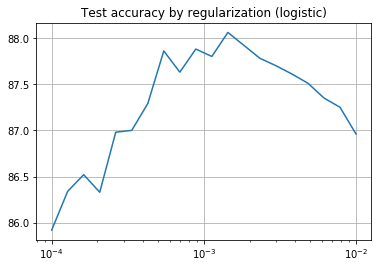

In [18]:
# Run the graph with a series of beta values.

num_steps = 3001
batch_size = 128
beta_vals = np.logspace(-4, -2, 20)
accuracy_vals = []

for beta_val in beta_vals:
  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta_val}
      _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    print("Beta value: %s, Test accuracy: %.1f%%" % (beta_val, accuracy(test_prediction.eval(), test_labels)))
    accuracy_vals.append(accuracy(test_prediction.eval(), test_labels))
    
plt.semilogx(beta_vals, accuracy_vals)
plt.grid(True)
plt.title('Test accuracy by regularization (logistic)')
plt.show()

Second, let's do the one-layer neural network.

In [22]:
# Build the graph.

batch_size = 128
hidden_size = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # This is the coefficient before L2 regularization 
    beta_regul = tf.placeholder(tf.float32)

    # Variables.
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_size]))
    b1 = tf.Variable(tf.zeros([hidden_size]))

    W2 = tf.Variable(tf.truncated_normal([hidden_size, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    y1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    logits = tf.matmul(y1, W2) + b2

    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    ) + beta_regul * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)

    y1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    valid_logits = tf.matmul(y1_valid, W2) + b2
    valid_prediction = tf.nn.softmax(valid_logits)

    y1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    test_logits = tf.matmul(y1_test, W2) + b2
    test_prediction = tf.nn.softmax(test_logits)

In [21]:
# Run the graph with a fixed beta value.

num_steps = 3001
batch_size = 128
beta_val = 1e-3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Graph initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta_val}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initializing
Initialized
Minibatch loss at step 0: 702.610718
Minibatch accuracy: 8.6%
Validation accuracy: 22.9%
Minibatch loss at step 500: 200.651917
Minibatch accuracy: 76.6%
Validation accuracy: 78.3%
Minibatch loss at step 1000: 115.667305
Minibatch accuracy: 76.6%
Validation accuracy: 81.7%
Minibatch loss at step 1500: 68.558823
Minibatch accuracy: 85.9%
Validation accuracy: 83.3%
Minibatch loss at step 2000: 42.423004
Minibatch accuracy: 82.8%
Validation accuracy: 84.3%
Minibatch loss at step 2500: 25.454895
Minibatch accuracy: 80.5%
Validation accuracy: 86.4%
Minibatch loss at step 3000: 15.426962
Minibatch accuracy: 88.3%
Validation accuracy: 86.9%
Test accuracy: 92.6%


Beta value: 0.0001, Test accuracy: 88.2%
Beta value: 0.00012742749857, Test accuracy: 88.6%
Beta value: 0.000162377673919, Test accuracy: 89.3%
Beta value: 0.000206913808111, Test accuracy: 89.4%
Beta value: 0.000263665089873, Test accuracy: 89.1%
Beta value: 0.000335981828628, Test accuracy: 89.7%
Beta value: 0.000428133239872, Test accuracy: 90.2%
Beta value: 0.000545559478117, Test accuracy: 90.7%
Beta value: 0.000695192796178, Test accuracy: 91.5%
Beta value: 0.00088586679041, Test accuracy: 92.1%
Beta value: 0.00112883789168, Test accuracy: 92.3%
Beta value: 0.00143844988829, Test accuracy: 92.9%
Beta value: 0.00183298071083, Test accuracy: 92.8%
Beta value: 0.00233572146909, Test accuracy: 92.5%
Beta value: 0.00297635144163, Test accuracy: 92.3%
Beta value: 0.00379269019073, Test accuracy: 91.9%
Beta value: 0.00483293023857, Test accuracy: 91.4%
Beta value: 0.00615848211066, Test accuracy: 90.7%
Beta value: 0.00784759970351, Test accuracy: 90.2%
Beta value: 0.01, Test accuracy: 8

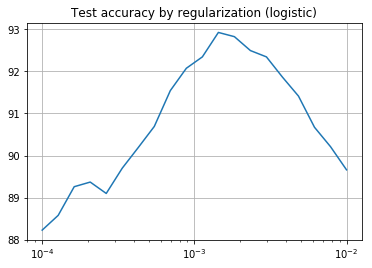

In [10]:
num_steps = 3001
batch_size = 128
beta_vals = np.logspace(-4, -2, 20)
accuracy_vals = []

for beta_val in beta_vals:
  with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for step in range(num_steps):
      # Pick an offset within the training data, which has been randomized.
      # Note: we could use better randomization across epochs.
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      # Generate a minibatch.
      batch_data = train_dataset[offset:(offset + batch_size), :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      # Prepare a dictionary telling the session where to feed the minibatch.
      # The key of the dictionary is the placeholder node of the graph to be fed,
      # and the value is the numpy array to feed to it.
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta_val}
      _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    print("Beta value: %s, Test accuracy: %.1f%%" % (beta_val, accuracy(test_prediction.eval(), test_labels)))
    accuracy_vals.append(accuracy(test_prediction.eval(), test_labels))

plt.semilogx(beta_vals, accuracy_vals)
plt.grid(True)
plt.title('Test accuracy by regularization (neural network)')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [5]:
# Build the graph.

batch_size = 128
hidden_size = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # This is the coefficient before L2 regularization 
    beta_regul = tf.placeholder(tf.float32)

    # Variables.
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_size]))
    b1 = tf.Variable(tf.zeros([hidden_size]))

    W2 = tf.Variable(tf.truncated_normal([hidden_size, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    y1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    logits = tf.matmul(y1, W2) + b2

    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    ) + beta_regul * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)

    y1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    valid_logits = tf.matmul(y1_valid, W2) + b2
    valid_prediction = tf.nn.softmax(valid_logits)

    y1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    test_logits = tf.matmul(y1_test, W2) + b2
    test_prediction = tf.nn.softmax(test_logits)

In [7]:
# Run the graph with a fixed beta value.

num_steps = 3001
batch_size = 128
num_of_batches = 3  # We only feed 3 different batches into the NN.
beta_val = 1e-3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Graph initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = ((step % num_of_batches) * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta_val}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initializing
Initialized
Minibatch loss at step 0: 641.318115
Minibatch accuracy: 10.9%
Validation accuracy: 20.7%
Minibatch loss at step 500: 190.610229
Minibatch accuracy: 100.0%
Validation accuracy: 74.0%
Minibatch loss at step 1000: 115.596634
Minibatch accuracy: 100.0%
Validation accuracy: 73.9%
Minibatch loss at step 1500: 70.104088
Minibatch accuracy: 100.0%
Validation accuracy: 73.8%
Minibatch loss at step 2000: 42.515179
Minibatch accuracy: 100.0%
Validation accuracy: 73.6%
Minibatch loss at step 2500: 25.784170
Minibatch accuracy: 100.0%
Validation accuracy: 73.6%
Minibatch loss at step 3000: 15.638687
Minibatch accuracy: 100.0%
Validation accuracy: 74.2%
Test accuracy: 80.4%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [5]:
# Build the graph.

batch_size = 128
hidden_size = 1024
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # This is the coefficient before L2 regularization 
    beta_regul = tf.placeholder(tf.float32)

    # Variables.
    W1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_size]))
    b1 = tf.Variable(tf.zeros([hidden_size]))

    W2 = tf.Variable(tf.truncated_normal([hidden_size, num_labels]))
    b2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    y1 = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    dropout1 = tf.nn.dropout(y1, keep_prob)
    logits = tf.matmul(y1, W2) + b2

    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    ) + beta_regul * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)

    y1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    valid_logits = tf.matmul(y1_valid, W2) + b2
    valid_prediction = tf.nn.softmax(valid_logits)

    y1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    test_logits = tf.matmul(y1_test, W2) + b2
    test_prediction = tf.nn.softmax(test_logits)

In [6]:
# Run the graph with a fixed beta value.

num_steps = 3001
batch_size = 128
beta_val = 1e-3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Graph initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta_val}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initializing
Initialized
Minibatch loss at step 0: 765.695068
Minibatch accuracy: 7.8%
Validation accuracy: 28.4%
Minibatch loss at step 500: 199.755768
Minibatch accuracy: 71.1%
Validation accuracy: 78.7%
Minibatch loss at step 1000: 114.147232
Minibatch accuracy: 79.7%
Validation accuracy: 83.0%
Minibatch loss at step 1500: 68.156570
Minibatch accuracy: 85.9%
Validation accuracy: 83.7%
Minibatch loss at step 2000: 41.798901
Minibatch accuracy: 82.0%
Validation accuracy: 83.2%
Minibatch loss at step 2500: 25.338974
Minibatch accuracy: 82.8%
Validation accuracy: 86.6%
Minibatch loss at step 3000: 15.308699
Minibatch accuracy: 93.0%
Validation accuracy: 87.2%
Test accuracy: 92.6%


In [7]:
# Run the graph with a fixed beta value.

num_steps = 3001
batch_size = 128
num_of_batches = 3  # We only feed 3 different batches into the NN.

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Graph initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = ((step % num_of_batches) * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initializing
Initialized
Minibatch loss at step 0: 641.948059
Minibatch accuracy: 14.8%
Validation accuracy: 31.4%
Minibatch loss at step 500: 190.845871
Minibatch accuracy: 100.0%
Validation accuracy: 73.4%
Minibatch loss at step 1000: 115.739418
Minibatch accuracy: 100.0%
Validation accuracy: 73.4%
Minibatch loss at step 1500: 70.190788
Minibatch accuracy: 100.0%
Validation accuracy: 73.3%
Minibatch loss at step 2000: 42.567680
Minibatch accuracy: 100.0%
Validation accuracy: 73.4%
Minibatch loss at step 2500: 25.815784
Minibatch accuracy: 100.0%
Validation accuracy: 73.6%
Minibatch loss at step 3000: 15.657446
Minibatch accuracy: 100.0%
Validation accuracy: 74.2%
Test accuracy: 80.6%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [5]:
batch_size = 128
hidden_size1 = 1024
hidden_size2 = 512
hidden_size3 = 256
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # This is the coefficient before L2 regularization 
    beta_regul = tf.placeholder(tf.float32)

    # Variables.
    W1 = tf.Variable(
        tf.truncated_normal(
            [image_size * image_size, hidden_size1],
            stddev=np.sqrt(2.0 / (image_size * image_size))
        )
    )
    b1 = tf.Variable(tf.zeros([hidden_size1]))
    
    W2 = tf.Variable(
        tf.truncated_normal(
            [hidden_size1, hidden_size2],
            stddev=np.sqrt(2.0 / hidden_size1)
        )
    )
    b2 = tf.Variable(tf.zeros([hidden_size2]))
    
    W3 = tf.Variable(
        tf.truncated_normal(
            [hidden_size2, hidden_size3], stddev=np.sqrt(2.0 / hidden_size2)
        )
    )
    b3 = tf.Variable(tf.zeros([hidden_size3]))
    
    W4 = tf.Variable(
        tf.truncated_normal(
                [hidden_size3, num_labels], 
                stddev=np.sqrt(2.0 / hidden_size3)
        )
    )
    b4 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    layer1_train = tf.nn.relu(tf.matmul(tf_train_dataset, W1) + b1)
    dropout1 = tf.nn.dropout(layer1_train, 0.5)
    
    layer2_train = tf.nn.relu(tf.matmul(dropout1, W2) + b2)
    dropout2 = tf.nn.dropout(layer2_train, 0.5)
    
    layer3_train = tf.nn.relu(tf.matmul(dropout2, W3) + b3)
    dropout3 = tf.nn.dropout(layer3_train, 0.5)
    
    logits = tf.matmul(dropout3, W4) + b4
    
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    loss += beta_regul * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3) + tf.nn.l2_loss(W4))

    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 5000, 0.80, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    layer1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, W1) + b1)
    layer2_valid = tf.nn.relu(tf.matmul(layer1_valid, W2) + b2)
    layer3_valid = tf.nn.relu(tf.matmul(layer2_valid, W3) + b3)
    valid_prediction = tf.nn.softmax(tf.matmul(layer3_valid, W4) + b4)
    
    layer1_test = tf.nn.relu(tf.matmul(tf_test_dataset, W1) + b1)
    layer2_test = tf.nn.relu(tf.matmul(layer1_test, W2) + b2)
    layer3_test = tf.nn.relu(tf.matmul(layer2_test, W3) + b3)
    test_prediction = tf.nn.softmax(tf.matmul(layer3_test, W4) + b4)

In [ ]:
num_steps = 20001
beta_val = 1e-3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Graph initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : beta_val}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.105654
Minibatch accuracy: 10.2%
Validation accuracy: 15.4%
Minibatch loss at step 500: 1.830279
Minibatch accuracy: 75.8%
Validation accuracy: 84.9%
Minibatch loss at step 1000: 1.320481
Minibatch accuracy: 81.2%
Validation accuracy: 85.6%
Minibatch loss at step 1500: 0.988955
Minibatch accuracy: 85.2%
Validation accuracy: 86.3%
Minibatch loss at step 2000: 0.989366
Minibatch accuracy: 79.7%
Validation accuracy: 87.0%
Minibatch loss at step 2500: 0.865957
Minibatch accuracy: 81.2%
Validation accuracy: 86.9%
Minibatch loss at step 3000: 0.687645
Minibatch accuracy: 85.9%
Validation accuracy: 87.0%
Minibatch loss at step 3500: 0.674933
Minibatch accuracy: 89.1%
Validation accuracy: 86.8%
Minibatch loss at step 4000: 0.782368
Minibatch accuracy: 81.2%
Validation accuracy: 87.3%
Minibatch loss at step 4500: 0.760099
Minibatch accuracy: 83.6%
Validation accuracy: 87.5%
Minibatch loss at step 5000: 0.631535
Minibatch accuracy: 85.2%
Validation accurac